In [56]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
import torch.nn as nn
import progressive_blocks
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

training_set = pd.read_csv('./Datasets/M4-Dataset/Train/Monthly-train.csv')

training_set = training_set.iloc[:,1:2] #electricity values in time
any_missing = training_set.isnull().any()
print(any_missing)
print("all training set length: ",len(training_set))

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)

path="Models/M4"




V2    False
dtype: bool
all training set length:  48000


In [57]:
train_set=training_set[:42500]
print(train_set.shape)

(42500, 1)


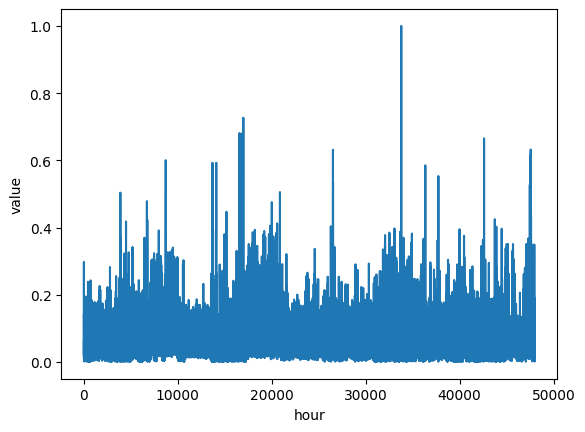

In [58]:
plt.xlabel('hour')
plt.ylabel('value')
plt.plot(training_set)
plt.show()

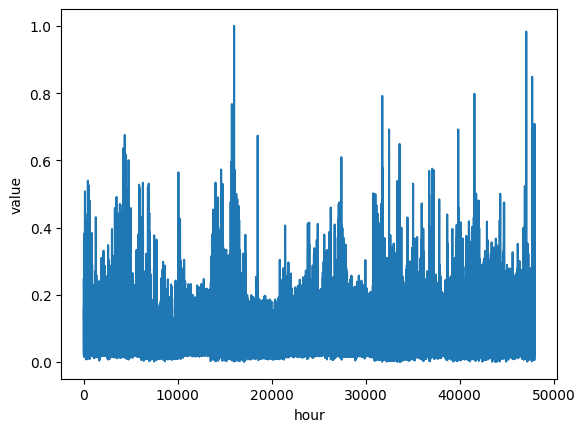

In [59]:
test_set = pd.read_csv('./Datasets/M4-Dataset/Test/Monthly-test.csv')

test_set = test_set.iloc[:,1:2].values
#test_set=test_set[:42500]
sc = MinMaxScaler()
test_set = sc.fit_transform(test_set)
plt.xlabel('hour')
plt.ylabel('value')
plt.plot(test_set)
plt.show()

In [60]:

seq_length = 512 #it is tau in the paper
x, y = utils.sliding_windows(train_set, seq_length)
trainX=torch.Tensor(np.array(x))
print(trainX.shape)
size=trainX.size(0)


torch.Size([41987, 512, 1])


In [61]:

sequences=utils.real_seq(training_set,seq_length)
sequences=sequences[:size]
print(sequences.dtype)
sequences=torch.Tensor(sequences)
sequences.unsqueeze(0).unsqueeze(1)
sequences=sequences.permute(0,2,1)
print(sequences.shape)


float64
torch.Size([41987, 1, 512])


# *TRAIN*

In [8]:

utils.create_folder(path)


The new models directory is created!


In [9]:
#Saved parameters for "2dafe model":

#discriminator_lr=0.00005
#generator_lr=0.00005
#num_epochs=24
#batch_size=121
#batch_size=347

#blocks_to_add=2
#activeG=(G.step-1)-blocks_to_add
#activeD=blocks_to_add
#timestamp=8


In [10]:
%%time

embedding_dim=10
batch_size=trainX.size(0)
value_features=1
key_features=1

#extract the number of features
num_features=trainX.size(2)+10

#Hyperparameters
discriminator_lr=0.00005
generator_lr=0.00005
num_epochs=27
#batch_size=121
batch_size=347
criterion = nn.MSELoss()
save = True
name_model = '2fade_prova_'
gpu = True


device=utils.assign_device(gpu)

#Initializations
train = TensorDataset(trainX, sequences)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False) 


D=progressive_blocks.Discriminator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features,device)
G=progressive_blocks.Generator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features,device)
optimD = Adam(D.parameters(), lr=discriminator_lr, betas=(0.9, 0.999))
optimG = Adam(G.parameters(), lr=generator_lr, betas=(0.9, 0.999))

blocks_to_add=2
activeG=(G.step-1)-blocks_to_add
activeD=blocks_to_add
timestamp=9
#timestamp=8

#Training
g_losses = []
d_losses = []
G.to(device)
D.to(device)
fade=1
sum_fade=0
g_loss_min=1000000
d_loss_min=1000000

print("Starting training:")
print("Total Epochs: %d \nBlocks to add with fade: %d\nTimestamp to add blocks: %d" % 
                    (num_epochs, blocks_to_add, timestamp))

for epoch in range(1,num_epochs+1):
        g_losses_temp=[]
        d_losses_temp=[]

        if (epoch%timestamp==0 and epoch!=0 and activeG!=G.step-1 and activeD!=0):
            activeD-=1
            activeG+=1
            fade=0
            sum_fade=1/((timestamp)/2)
            #sum_fade=1/(timestamp)
            print("Block added")

        elif(fade+sum_fade<=1):
            fade+=sum_fade

        else:
            fade=1

        for i, (X, Y) in enumerate((train_loader)):
            #print("i:",i)
            #print("X in (train_loader):",X.shape)
            #print("Y:",Y.shape)
            
            X=X.to(device)
            Y=Y.to(device)
            # Generate fake data
            
            fake_data = G(X,fade,activeG)
            fake_label = torch.zeros(Y.size(0))
            
           
            # Train the discriminator
            Y=Y[:,:,:fake_data.size(2)]  #we use this to adapt real sequences length to fake sequences length
           
            D.zero_grad()
            d_real_loss = criterion(D(Y,X,fade,activeD), torch.ones_like(D(Y,X,fade,activeD)))
            d_fake_loss = criterion(D(fake_data.detach(),X,fade,activeD), torch.zeros_like(D(fake_data.detach(),X,fade,activeD)))
            d_loss = d_real_loss + d_fake_loss
            d_losses_temp.append(d_loss.item())
            d_loss.backward(retain_graph=False)
            optimD.step()
            
            # Train the generator
            G.zero_grad()
            g_loss = criterion(D(fake_data,X,fade,activeD), torch.ones_like(D(fake_data,X,fade,activeD)))

            # Add the moment loss
            g_loss += utils.moment_loss(fake_data, Y)
            #g_loss = utils.moment_loss(fake_data, Y)
            g_losses_temp.append(g_loss.item())

            g_loss.backward()
            optimG.step()
            
            # Print the losses
            if (i+1) % 1 == 0:
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [Fade-in: %f]" % 
                    (epoch, num_epochs, i+1, len(train_loader), d_loss.item(), g_loss.item(), fade))
            
            if(g_loss<g_loss_min and d_loss<d_loss_min and save):
                    g_loss_min = g_loss
                    d_loss_min = d_loss
                    torch.save(G, path+'/'+name_model+'generator_model.pt')
                    torch.save(D, path+'/'+name_model+'discriminator_model.pt')
                    print('Improvement-Detected, model saved')


        g_losses.append(torch.mean(torch.Tensor(g_losses_temp)))
        d_losses.append(torch.mean(torch.Tensor(d_losses_temp)))

Cuda enabled: using GPU
Starting training:
Total Epochs: 27 
Blocks to add with fade: 2
Timestamp to add blocks: 9
[Epoch 1/27] [Batch 1/121] [D loss: 0.729964] [G loss: 0.865646] [Fade-in: 1.000000]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 2/121] [D loss: 0.724218] [G loss: 0.833049] [Fade-in: 1.000000]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 3/121] [D loss: 0.722690] [G loss: 0.821067] [Fade-in: 1.000000]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 4/121] [D loss: 0.721144] [G loss: 0.812726] [Fade-in: 1.000000]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 5/121] [D loss: 0.719675] [G loss: 0.808841] [Fade-in: 1.000000]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 6/121] [D loss: 0.718227] [G loss: 0.798742] [Fade-in: 1.000000]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 7/121] [D loss: 0.716794] [G loss: 0.792198] [Fade-in: 1.000000]
Improvement-Detected, model saved
[Epoch 1/27] [Batch 8/121] [D loss: 0.715382] [G los

End-training Generator Loss: tensor(0.2726)
End-training Discriminator Loss: tensor(0.5000)


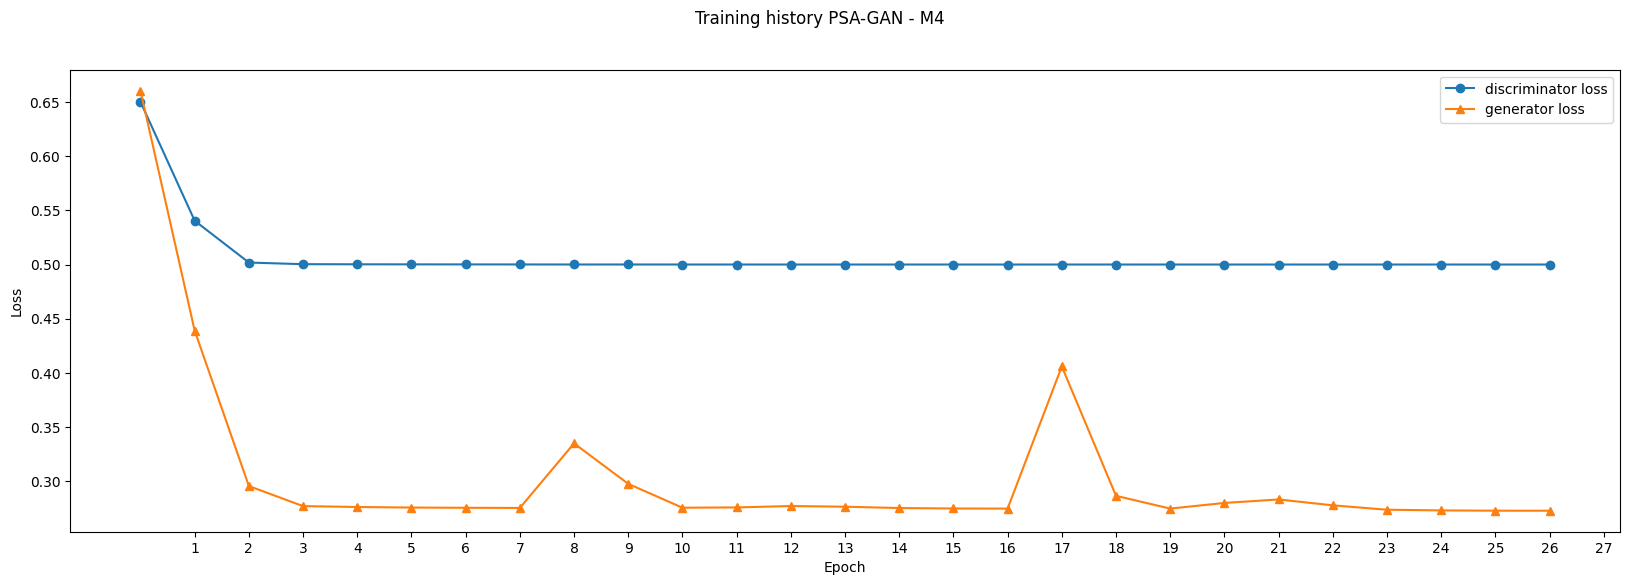

In [11]:

utils.plot_training_history('PSA-GAN - M4',d_losses, g_losses)


LOAD MODEL

In [12]:
load=True
name_model = '2fade_prova_'
if(load):
    G = torch.load(path+'/'+name_model+'generator_model.pt')
    D = torch.load(path+'/'+name_model+'discriminator_model.pt')

Predictions on the train set


generated_series:  torch.Size([347, 512, 1])


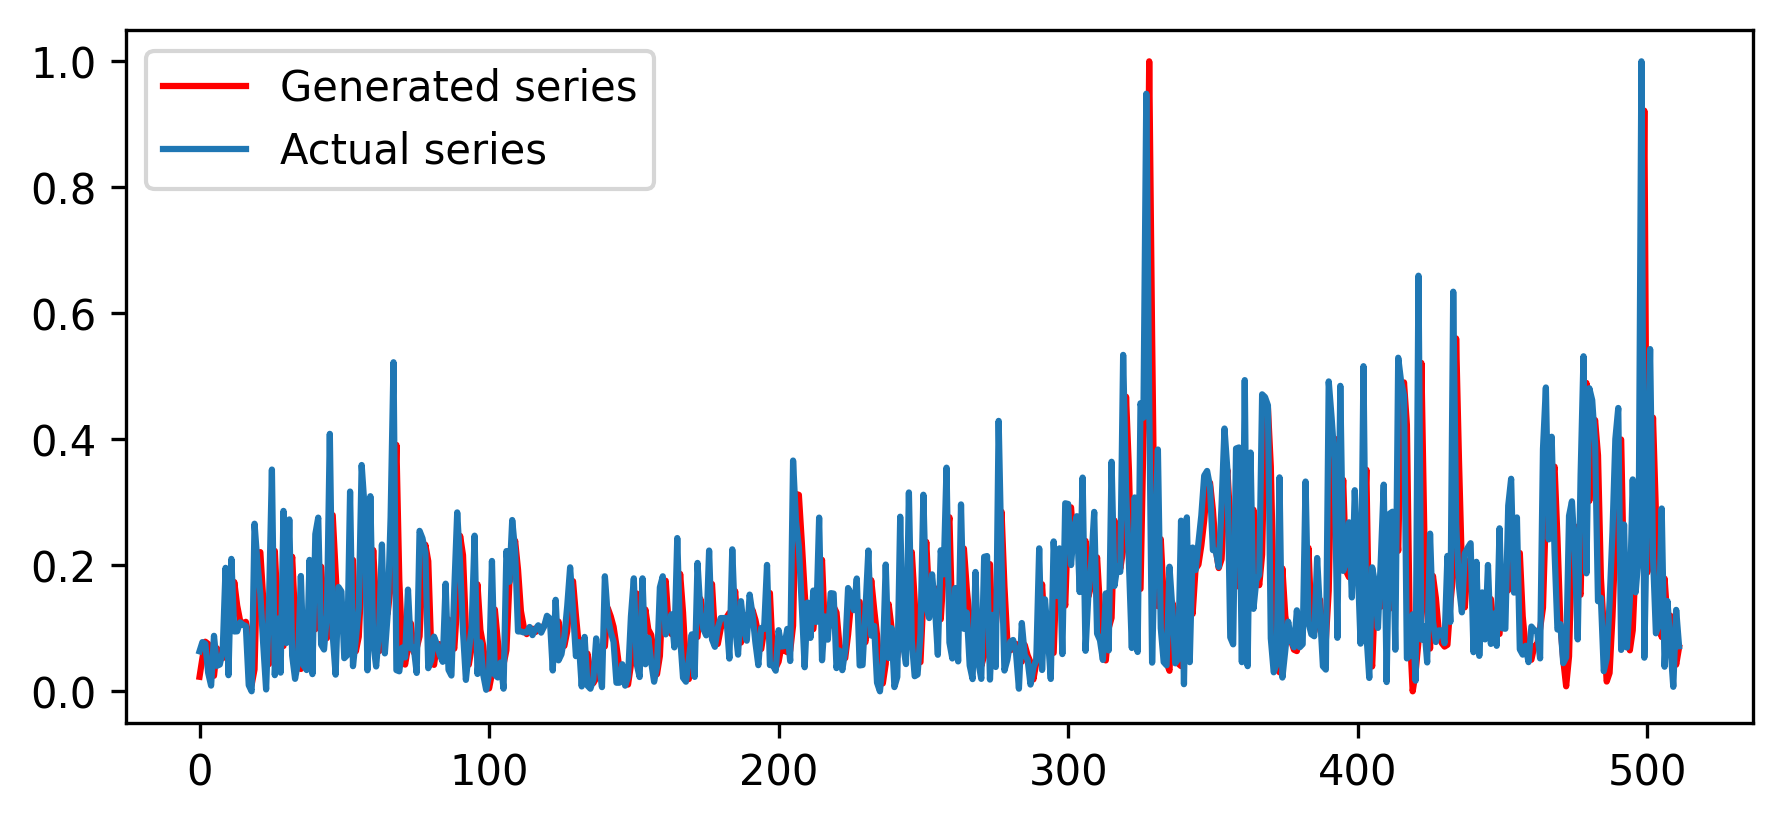

Parameter containing:
tensor([-0.0059], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0019], device='cuda:0', requires_grad=True)


In [13]:
t = train_set[len(trainX):len(trainX)+seq_length]
batch_size=347
#batch_size=121
with torch.no_grad():
    
    generated_series = G(trainX[len(trainX)-batch_size:],1,(G.step-1)) 
    generated_series=generated_series.permute(0,2,1)
    print("generated_series: ",generated_series.shape)
    generated_series = generated_series.to("cpu").detach().numpy()



generated_series[batch_size-1]=utils.scale(generated_series[batch_size-1])
aux=utils.scale(t)



plt.figure(figsize=(7, 3), dpi=300)


plt.plot(generated_series[batch_size-1], label='Generated series', color="red")
plt.plot(aux, label='Actual series', )

plt.suptitle(f'Train set: {name_model}')
plt.legend()
plt.show()

print(G.main.attn.gamma)
print(G.blocks[0].attn.gamma)

In [67]:
load=True
name_model = '2fade30_'
if(load):
    G = torch.load(path+'/'+name_model+'generator_model.pt')
    D = torch.load(path+'/'+name_model+'discriminator_model.pt')

Predictions on the Test set

torch.Size([41987, 512, 1])
generated_series:  torch.Size([347, 512, 1])


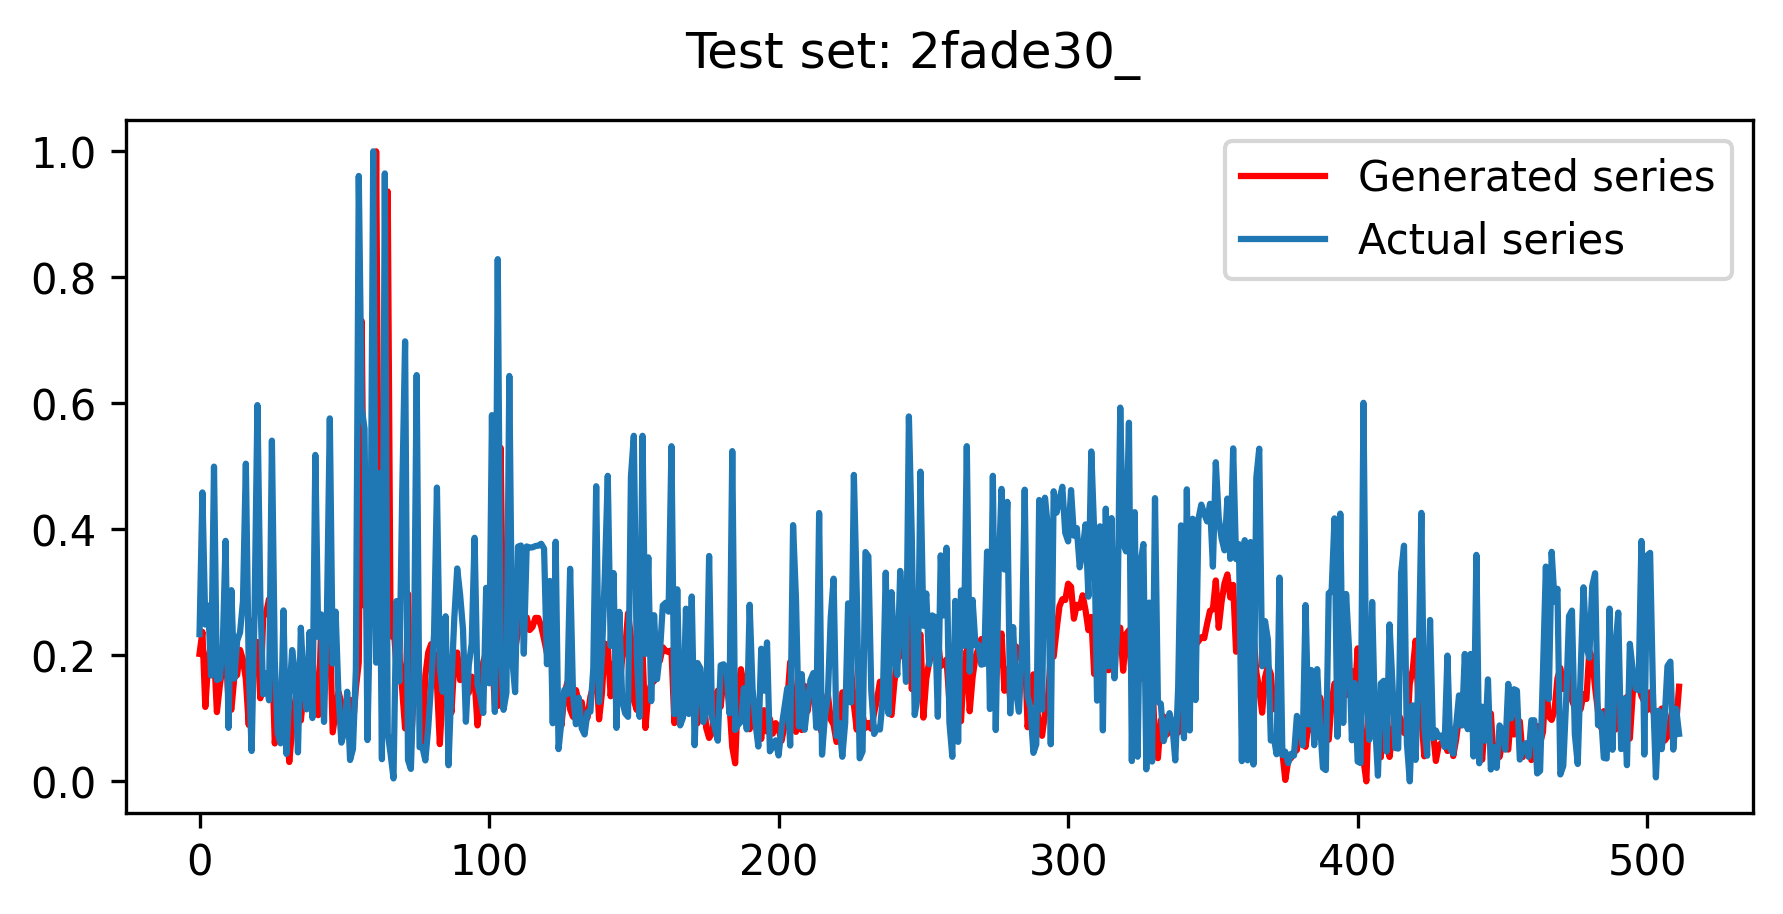

Parameter containing:
tensor([-0.0101], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0069], device='cuda:0', requires_grad=True)


In [68]:
#test_set

test = test_set[:42500]


seq_length = 512 #it is tau in the paper

x, y = utils.sliding_windows(test, seq_length)
testX=torch.Tensor(np.array(x))
print(testX.shape)
size=testX.size(0)
batch_size=347

t = test[len(testX):len(testX)+seq_length]

with torch.no_grad():
    
    generated_series = G(testX[len(testX)-batch_size:],1,(G.step-1)) 
    generated_series=generated_series.permute(0,2,1)
    print("generated_series: ",generated_series.shape)
    generated_series = generated_series.to("cpu").detach().numpy()


generated_series[batch_size-1]=utils.scale(generated_series[batch_size-1])
aux=utils.scale(t)


plt.figure(figsize=(7, 3), dpi=300)


plt.plot(generated_series[batch_size-1], label='Generated series', color="red")
plt.plot(aux, label='Actual series', )

plt.suptitle(f'Test set: {name_model}')
plt.legend()
plt.show()

print(G.main.attn.gamma)
print(G.blocks[0].attn.gamma)



## Some evaluations

In [69]:
generated_series[batch_size-1]
aux

mse=utils.mse(generated_series, aux)
print("Mean Square Error on test set: ",mse)

abs=utils.abs_error(generated_series, aux)
print("Absolute Error on test set: ",abs)

nrmse=utils.nrmse(generated_series, aux)
print("NRMSE on test set: ",nrmse)

Mean Square Error on test set:  0.08069066492470905
Absolute Error on test set:  39327.489306414165
NRMSE on test set:  0.2840610232409738


In [70]:
seq_length = 512 #it is tau in the paper
batch_size=347
x, y = utils.sliding_windows(test_set, seq_length)
testX=torch.Tensor(np.array(x))
print("testX.shape:",testX.shape)
size=testX.size(0)

sequences=utils.real_seq(test_set,seq_length)
sequences=sequences[:size]
print(sequences.dtype)
sequences=torch.Tensor(sequences)
sequences.unsqueeze(0).unsqueeze(1)
sequences=sequences.permute(0,2,1)
print("Sequence.shape:",sequences.shape)

testX=testX[:len(testX)-seq_length]
print("testX.shape",testX.shape)
test= TensorDataset(testX, sequences)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False) 

testX.shape: torch.Size([47487, 512, 1])
float64
Sequence.shape: torch.Size([46975, 1, 512])
testX.shape torch.Size([46975, 512, 1])


In [81]:
from tqdm import tqdm
def evaluation(eval):
    
    results=[]
    with torch.no_grad():
        '''
        for i, (X, Y) in enumerate((test_loader)):
            generated_series = G(testX[len(testX)-batch_size:],1,(G.step-1)) 
            generated_series=generated_series.permute(0,2,1)
            generated_series = generated_series.to("cpu").detach().numpy()

            generated_series[batch_size-1]=utils.scale(generated_series[batch_size-1])
            aux=utils.scale(t)

            result=nrmse=utils.nrmse(generated_series, aux)
            results.append(result)
            '''
        device='cuda'
        G.to(device)
        for i, (X, Y) in tqdm(enumerate((test_loader)), total=len(test_loader)):
            #print(i)
            if(i==135):
                break
                print("Critic point")
            X=X.to(device)
            Y=Y.to(device)
            
            fake_data = G(X,1,(G.step-1))
            real_data=Y[:,:,:fake_data.size(2)].to("cpu")

            fake_data=fake_data.permute(0,2,1)
            fake_data = fake_data.to("cpu").detach().numpy()
            real_data = real_data.to("cpu").detach().numpy()

            #fake_data=utils.scale(fake_data)
            #real_data=utils.scale(real_data)

            if(eval=="NRMSE"):
                result=utils.nrmse(fake_data, real_data)
                results.append(result)
            elif(eval=="MSE"):
                result=utils.mse(fake_data, real_data)
                results.append(result)
            elif(eval=="ABS"):
                result=utils.abs_error(fake_data, real_data)
                results.append(result)
            else:
                print("error")
                break

    res_mean=np.mean(results)
    res_stdev=np.std(results)

    return res_mean, res_stdev


In [82]:
mean, std_dev = evaluation("NRMSE")
print("NRMSE =",mean,"+-",std_dev)

 99%|█████████▉| 135/136 [00:38<00:00,  3.49it/s]

NRMSE = 0.38973212 +- 0.14657983


In [83]:
mean, std_dev = evaluation("MSE")
print("MSE =",mean,"+-",std_dev)

 99%|█████████▉| 135/136 [00:38<00:00,  3.47it/s]

MSE = 0.025378771 +- 0.003697756


In [84]:
mean, std_dev = evaluation("ABS")
print("ABS =",mean,"+-",std_dev)

 99%|█████████▉| 135/136 [00:38<00:00,  3.47it/s]

ABS = 11256684.0 +- 856056.56
